In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_squared_error as auto_mean_squared_error
from pprint import pprint

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyparsing.py:3172: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [2]:
# load dataset
debt_price_df = pd.read_csv('debt_price_df.csv', index_col='date', parse_dates=True)


def fitmodel(data_to_fit=debt_price_df, 
             data_to_predict=debt_price_df, 
             target_col='p',
             features=None, 
             verbose=False, 
             test_size=0.33
            ):
    if not features:
        features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
                    'rho_star', 'C_star',
                    'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
                    'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
                    'D']
    target = data_to_fit[target_col].copy()
    
    def transform(df):        
        df = df[features].copy()
        df_deltas = df.diff()
        df_deltas.iloc[0] = df.iloc[0].copy()
        df = df.join(df_deltas, rsuffix='_delta')
        return df
    
    data_to_fit = transform(data_to_fit)
    data_to_predict = transform(data_to_predict)
    
    X_train, X_test, y_train, y_test = train_test_split(data_to_fit, target, test_size=test_size, random_state=1)
    
    model = AutoSklearnRegressor(time_left_for_this_task=5*60, per_run_time_limit=30, n_jobs=8)
    model.fit(X_train, y_train)
    if verbose:
        print(model.sprint_statistics())
        models = model.get_models_with_weights()
        for m in models:
            print({m[0]: m[1].config['regressor:__choice__']})
    return model, model.predict(data_to_predict)

def get_model_summary(model):
    result = []
    models = model.get_models_with_weights()
    for m in models:
        result.append((m[0],m[1].config['regressor:__choice__']))
    return result

In [ ]:
estimates = pd.DataFrame(debt_price_df['p'])
models = []

print('Fitting model using 66% of the data for training')
a,b = fitmodel()
models.append(a)
estimates['p_hat_1'] = b
pprint(get_model_summary(a))
print('---')

print('Fitting model using 66% of the first half of the data for training')
a,b = fitmodel(data_to_fit=debt_price_df[:len(debt_price_df)//2])
models.append(a)
estimates['p_hat_2'] = b
pprint(get_model_summary(a))
print('---')

print('Fitting model using 40% of the data for training')
a,b = fitmodel(test_size=0.6)
models.append(a)
estimates['p_hat_3'] = b
pprint(get_model_summary(a))
print('---')

print('Fitting model using 25% of the data for training')
a,b = fitmodel(test_size=0.75)
models.append(a)
estimates['p_hat_4'] = b
pprint(get_model_summary(a))
print('---')

estimates.plot(figsize=(15,5))

Fitting model using 66% of the data for training
[WARNING] [2020-09-15 11:36:59,324:AutoMLSMBO(1791095845)::b56d6514e5d15838099c9b29b60fa175] Could not find meta-data directory /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/metalearning/files/r2_regression_dense
[(0.3, 'k_nearest_neighbors'),
 (0.26, 'adaboost'),
 (0.22, 'adaboost'),
 (0.08, 'gaussian_process'),
 (0.08, 'ridge_regression'),
 (0.04, 'decision_tree'),
 (0.02, 'gradient_boosting')]
---
Fitting model using 40% of the data for training
[WARNING] [2020-09-15 11:42:08,753:AutoMLSMBO(1791095845)::5bdea8deee5acc242ff3059bfb1622ce] Could not find meta-data directory /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/metalearning/files/r2_regression_dense
[(0.6000000000000001, 'k_nearest_neighbors'),
 (0.18000000000000002, 'ridge_regression'),
 (0.12000000000000001, 'adaboost'),
 (0.10000000000000002, 'ard_regression')]
---
Fitting model using 25% o

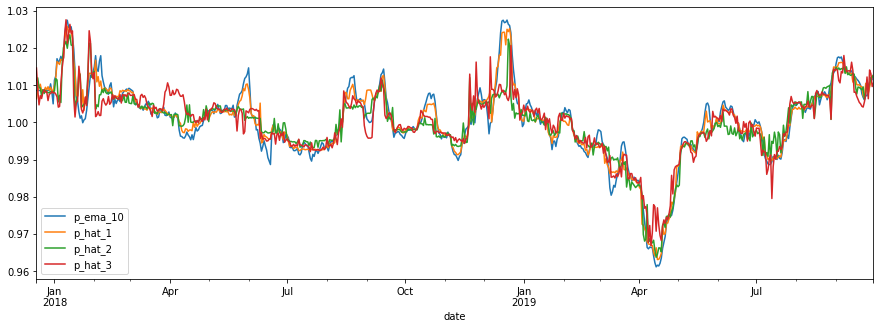

In [3]:
estimates = pd.DataFrame(debt_price_df['p_ema_10'])
models = []

print('Fitting model using 66% of the data for training')
a,b = fitmodel(target_col='p_ema_10')
models.append(a)
estimates['p_hat_1'] = b
pprint(get_model_summary(a))
print('---')

print('Fitting model using 40% of the data for training')
a,b = fitmodel(test_size=0.6, target_col='p_ema_10')
models.append(a)
estimates['p_hat_2'] = b
pprint(get_model_summary(a))
print('---')

print('Fitting model using 25% of the data for training')
a,b = fitmodel(test_size=0.75, target_col='p_ema_10')
models.append(a)
estimates['p_hat_3'] = b
pprint(get_model_summary(a))
print('---')

estimates.plot(figsize=(15,5))

In [17]:
autoreg_df = debt_price_df[['p', 'p_star']].copy()
autoreg_df['p_hat'] = b
autoreg_df['e_hat'] = autoreg_df['p_hat'] - autoreg_df['p']
autoreg_df['e_star'] = autoreg_df['p_star'] - autoreg_df['p']
autoreg_df['cumsum_e_hat'] = autoreg_df['e_hat'].cumsum()
autoreg_df['cumsum_e_star'] = autoreg_df['e_star'].cumsum()
autoreg_df['delta_e_hat'] = autoreg_df['e_hat'].diff().fillna(autoreg_df['e_hat'])
autoreg_df['delta_e_star'] = autoreg_df['e_star'].diff().fillna(autoreg_df['e_star'])
autoreg_df['y'] = autoreg_df['p'].shift(-1)
autoreg_df.dropna(inplace=True)

0.5322352924371445
[ 1.00046953  0.29772332  0.06890718  0.00843681  0.00140638 -0.15692076
  0.27285563]
0.0
0.5322352924371436
[ 0.46578117  0.29772332 -0.46578117  0.00843681  0.00140638 -0.15692076
  0.27285563]
0.5346883550095554


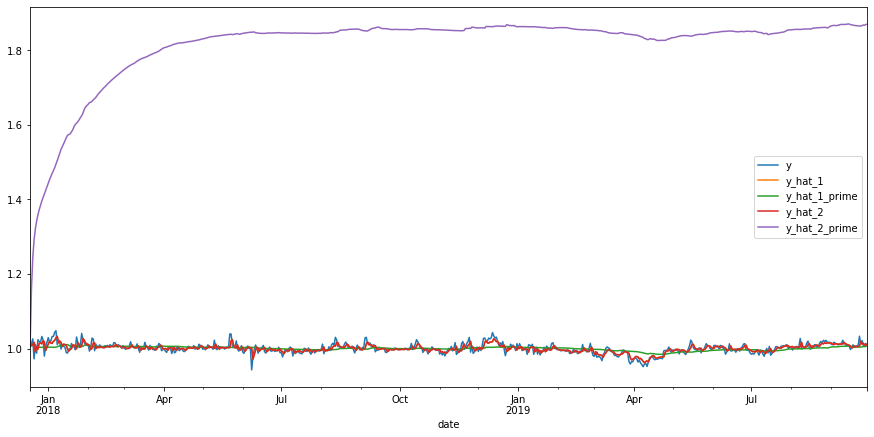

In [56]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = autoreg_df[['p', 
                'e_hat', 'e_star', 
                'cumsum_e_hat', 'cumsum_e_star', 
                'delta_e_hat', 'delta_e_star']]
y = autoreg_df['y']
reg = LinearRegression(fit_intercept=False).fit(X.sample(n=200,random_state=1), y.sample(n=200,random_state=1))
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
autoreg_df['y_hat_1'] = reg.predict(X)

y_hat_3 = [autoreg_df['p'].iloc[0]]
prev_e_hat = 0
prev_e_star = 0
cumsum_e_hat = 0
cumsum_e_star = 0
for i,r in autoreg_df.iterrows():
    p = y_hat_3[-1]
    e_hat = r['p_hat'] - p
    e_star = r['p_star'] - p
    cumsum_e_hat += e_hat
    cumsum_e_star += e_star
    delta_e_hat = e_hat - prev_e_hat
    delta_e_star = e_star - prev_e_star
    pred = (p * reg.coef_[0] +
            e_hat * reg.coef_[1] + 
            e_star * reg.coef_[2] +
            cumsum_e_hat * reg.coef_[3] +
            cumsum_e_star * reg.coef_[4] +
            delta_e_hat * reg.coef_[5] +
            delta_e_star * reg.coef_[6] +
            reg.intercept_)
    y_hat_3.append(pred)
autoreg_df['y_hat_1_prime'] = y_hat_3[:-1]

reg = LinearRegression().fit(X.sample(n=200,random_state=1), y.sample(n=200,random_state=1))
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
autoreg_df['y_hat_2'] = reg.predict(X)


y_hat_3 = [autoreg_df['p'].iloc[0]]
prev_e_hat = 0
prev_e_star = 0
cumsum_e_hat = 0
cumsum_e_star = 0
for i,r in autoreg_df.iterrows():
    p = y_hat_3[-1]
    e_hat = 2*r['p_hat'] - p
    e_star = r['p_star'] - p
    cumsum_e_hat += e_hat
    cumsum_e_star += e_star
    delta_e_hat = e_hat - prev_e_hat
    delta_e_star = e_star - prev_e_star
    pred = (p * reg.coef_[0] +
            e_hat * reg.coef_[1] + 
            e_star * reg.coef_[2] +
            cumsum_e_hat * reg.coef_[3] +
            cumsum_e_star * reg.coef_[4] +
            delta_e_hat * reg.coef_[5] +
            delta_e_star * reg.coef_[6] +
            reg.intercept_)
    y_hat_3.append(pred)
autoreg_df['y_hat_2_prime'] = y_hat_3[:-1]

autoreg_df.plot(y=['y','y_hat_1','y_hat_1_prime','y_hat_2','y_hat_2_prime'], figsize=(15,7))


-2244.321741920326
[ 10.51549307 -14.42248728   2.06534017  -1.04002705   4.01324015
  -6.45738358]
0.0
0.5322352924371436
[ 0.29772332 -0.93156235  0.00843681  0.00140638 -0.15692076  0.27285563]
1.0004695298950463


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


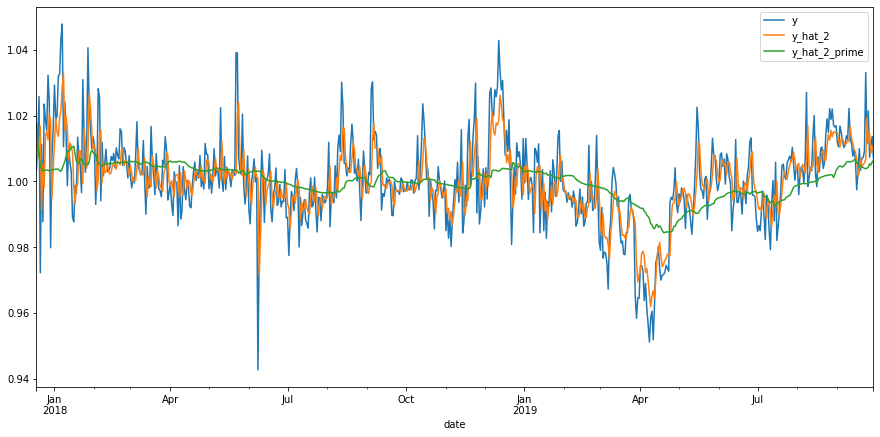

In [55]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = autoreg_df[['e_hat', 'e_star', 
                'cumsum_e_hat', 'cumsum_e_star', 
                'delta_e_hat', 'delta_e_star']]
y = autoreg_df['y']
reg = LinearRegression(fit_intercept=False).fit(X.sample(n=200,random_state=1), y.sample(n=200,random_state=1))
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
autoreg_df['y_hat_1'] = reg.predict(X)

y_hat_3 = [autoreg_df['p'].iloc[0]]
prev_e_hat = 0
prev_e_star = 0
cumsum_e_hat = 0
cumsum_e_star = 0
for i,r in autoreg_df.iterrows():
    p = y_hat_3[-1]
    e_hat = r['p_hat'] - p
    e_star = r['p_star'] - p
    cumsum_e_hat += e_hat
    cumsum_e_star += e_star
    delta_e_hat = e_hat - prev_e_hat
    delta_e_star = e_star - prev_e_star
    pred = (e_hat * reg.coef_[0] + 
            e_star * reg.coef_[1] +
            cumsum_e_hat * reg.coef_[2] +
            cumsum_e_star * reg.coef_[3] +
            delta_e_hat * reg.coef_[4] +
            delta_e_star * reg.coef_[5] +
            reg.intercept_)
    y_hat_3.append(pred)
autoreg_df['y_hat_1_prime'] = y_hat_3[:-1]

reg = LinearRegression().fit(X.sample(n=200,random_state=1), y.sample(n=200,random_state=1))
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
autoreg_df['y_hat_2'] = reg.predict(X)

y_hat_3 = [autoreg_df['p'].iloc[0]]
prev_e_hat = 0
prev_e_star = 0
cumsum_e_hat = 0
cumsum_e_star = 0
for i,r in autoreg_df.iterrows():
    p = y_hat_3[-1]
    e_hat = r['p_hat'] - p
    e_star = r['p_star'] - p
    cumsum_e_hat += e_hat
    cumsum_e_star += e_star
    delta_e_hat = e_hat - prev_e_hat
    delta_e_star = e_star - prev_e_star
    pred = (e_hat * reg.coef_[0] + 
            e_star * reg.coef_[1] +
            cumsum_e_hat * reg.coef_[2] +
            cumsum_e_star * reg.coef_[3] +
            delta_e_hat * reg.coef_[4] +
            delta_e_star * reg.coef_[5] +
            reg.intercept_)
    y_hat_3.append(pred)
autoreg_df['y_hat_2_prime'] = y_hat_3[:-1]

autoreg_df.plot(y=['y',
#                    'y_hat_1',
#                    'y_hat_1_prime',
                   'y_hat_2','y_hat_2_prime'], figsize=(15,7))
# autoreg_df.plot(y=['y','y_hat_2'], figsize=(15,7))

In [18]:
estimates = pd.DataFrame(autoreg_df['y'])
models = []

print('Fitting model using 66% of the data for training')
a,b = fitmodel(data_to_fit=autoreg_df, 
             data_to_predict=autoreg_df, 
             target_col='y',
             features=['p', 
                       'e_hat', 'e_star', 
                       'cumsum_e_hat', 'cumsum_e_star', 
                       'delta_e_hat', 'delta_e_star'],
             verbose=False, 
             test_size=0.33
            )
models.append(a)
estimates['y_hat_1'] = b
pprint(get_model_summary(a))
print('---')

print('Fitting model using 40% of the data for training')
a,b = fitmodel(data_to_fit=autoreg_df, 
             data_to_predict=autoreg_df, 
             target_col='y',
             features=['p', 
                       'e_hat', 'e_star', 
                       'cumsum_e_hat', 'cumsum_e_star', 
                       'delta_e_hat', 'delta_e_star'],
             verbose=False, 
             test_size=0.6
            )
models.append(a)
estimates['y_hat_1'] = b
pprint(get_model_summary(a))
print('---')

print('Fitting model using 25% of the data for training')
a,b = fitmodel(data_to_fit=autoreg_df, 
             data_to_predict=autoreg_df, 
             target_col='y',
             features=['p', 
                       'e_hat', 'e_star', 
                       'cumsum_e_hat', 'cumsum_e_star', 
                       'delta_e_hat', 'delta_e_star'],
             verbose=False, 
             test_size=0.75
            )
models.append(a)
estimates['y_hat_1'] = b
pprint(get_model_summary(a))
print('---')

estimates.plot(figsize=(15,5))

Fitting model using 66% of the data for training
[WARNING] [2020-09-15 12:02:24,580:AutoMLSMBO(1791095845)::02eaf23038aedb43387989c0858994f3] Could not find meta-data directory /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/metalearning/files/r2_regression_dense


Process Process-86:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/estimators.py", line 16, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/automl.py", line 1221, in fit
    load_models=load_models,
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/automl.py", line 615, in fit
    _proc_smac.run_smbo()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/smbo.py", line 473, in run_smbo
    sma

  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/estimators.py", line 16, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/automl.py", line 1221, in fit
    load_models=load_models,
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/automl.py", line 1221, in fit
    load_models=load_models,
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/automl.py", line 615, in fit
    _proc_smac.run_smbo()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/automl.py", line 615, in fit
    _proc_sma

KeyboardInterrupt
KeyboardInterrupt
Process pynisher function call:
Process Process-90:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/estimators.py", line 16, in _fit_automl
    return automl.fit(load_models=load_models, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/automl.py", line 1221, in fit
    load_models=load_models,
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/autosklearn/automl.py", line 615, in fit
    _proc_smac.run_smbo()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3

KeyboardInterrupt: 

In [ ]:
X = autoreg_df.drop(columns=['p', 'p_hat', 'p_star'])
y = autoreg_df['p'].copy()

from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

test_size = int(0.3*len(X))
X_train, X_test, train, test = X[:test_size], X[test_size:], y[:test_size], y[test_size:]

# train autoregression
model = AutoReg(train, 1, exog=X_train)        
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, exog_oos=X_test)
# for i in range(len(predictions)):
#     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
autoreg_df['market_p'] = list(train) + list(predictions)
autoreg_df.plot(y=['p','p_hat','p_star','market_p'], figsize=(15,5))
# # plot results
# pyplot.plot(test
# pyplot.plot(predictions, color='red')
# pyplot.show()